##### Optical depth computation for SIE lens model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from matplotlib.patches import Patch
import math
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.integrate import quad

Equation (A13) taken from https://arxiv.org/abs/1807.07062

Let us define,
$$ A \equiv \sqrt{\frac{q}{1-q^2}} $$

$$
f(\phi; y_1,y_2,q) = \Bigg[y_1 + A \, \operatorname{arcsinh}\!\left(\frac{\sqrt{1-q^2}}{q}\cos\phi\right)
\Bigg]\sin\phi
-
\Bigg[y_2 + A \, \arcsin\!\left(\sqrt{1-q^2}\sin\phi\right)\Bigg]\cos\phi= 0
$$

Acceptance condition (A14)
$$
\Bigg[y_1 + A \, \operatorname{arcsinh}\!\left(\frac{\sqrt{1-q^2}}{q}\cos\phi\right)\Bigg]\cos\phi
+
\Bigg[y_2 + A \, \arcsin\!\left(\sqrt{1-q^2}\sin\phi\right)\Bigg]\sin\phi > 0
$$

In [2]:
# ==================================================
# Eq. (A13)
# ==================================================
def f_A13(phi, y1, y2, q):
    A = np.sqrt(q / (1 - q**2))
    term1 = y1 + A * np.arcsinh(np.sqrt(1 - q**2)/q * np.cos(phi))
    term2 = y2 + A * np.arcsin(np.sqrt(1 - q**2) * np.sin(phi))
    return term1 * np.sin(phi) - term2 * np.cos(phi)

# ==================================================
# Acceptance condition (A14)
# ==================================================
def accept_A14(phi, y1, y2, q):
    A = np.sqrt(q / (1 - q**2))
    term1 = y1 + A * np.arcsinh(np.sqrt(1 - q**2)/q * np.cos(phi))
    term2 = y2 + A * np.arcsin(np.sqrt(1 - q**2) * np.sin(phi))
    return term1 * np.cos(phi) + term2 * np.sin(phi) > 0

# ==================================================
# Root finder
# ==================================================
def find_phi_roots(y1, y2, q, Nphi=1200):
    phis = np.linspace(0, 2*np.pi, Nphi)
    fvals = f_A13(phis, y1, y2, q)

    roots = []
    for i in range(len(phis)-1):
        if fvals[i] * fvals[i+1] < 0:
            try:
                root = brentq(f_A13, phis[i], phis[i+1], args=(y1, y2, q))
                roots.append(root)
            except ValueError:
                pass

    roots = np.unique(np.round(roots, 6))
    roots = [phi for phi in roots if accept_A14(phi, y1, y2, q)]
    return roots

# ==================================================
# Cross sections for a given q
# ==================================================
def cross_sections_for_q(q, Ny=200, ymax=2.5): #Ny = 200
    y1 = np.linspace(-ymax, ymax, Ny)
    y2 = np.linspace(-ymax, ymax, Ny)
    dy = y1[1] - y1[0]

    Y1, Y2 = np.meshgrid(y1, y2)
    Nimg = np.zeros((Ny, Ny), dtype=int)

    for i in range(Ny):
        for j in range(Ny):
            roots = find_phi_roots(Y1[i, j], Y2[i, j], q)
            Nimg[i, j] = len(roots)

    ## DISJOINT masks
    mask_4_ = (Nimg == 4)
    mask_2_ = (Nimg == 2)
    mask_net = (Nimg >= 2) ## net image region
    
    mask_4 = mask_net & (~mask_2_)   ## quad-only region
    mask_2__ = mask_net & (~mask_4_)
    mask_2 = mask_net & (~(mask_net & (~mask_4) + 1 * mask_2__)) ## double-only region
    
    ## cross section(s)
    sigma_4 = np.sum(mask_4) * dy**2
    sigma_2 = np.sum(mask_2) * dy**2
    sigma_net = np.sum(mask_net) * dy**2


    return sigma_2, sigma_4, sigma_net, y1, y2, mask_2, mask_4, mask_net

SIE 2-image cross-section (normalized to SIS):  0.670958512160229
SIE 4-image cross-section (normalized to SIS):  0.32618025751072965
SIE total cross-section (normalized to SIS):  0.7453505007153075


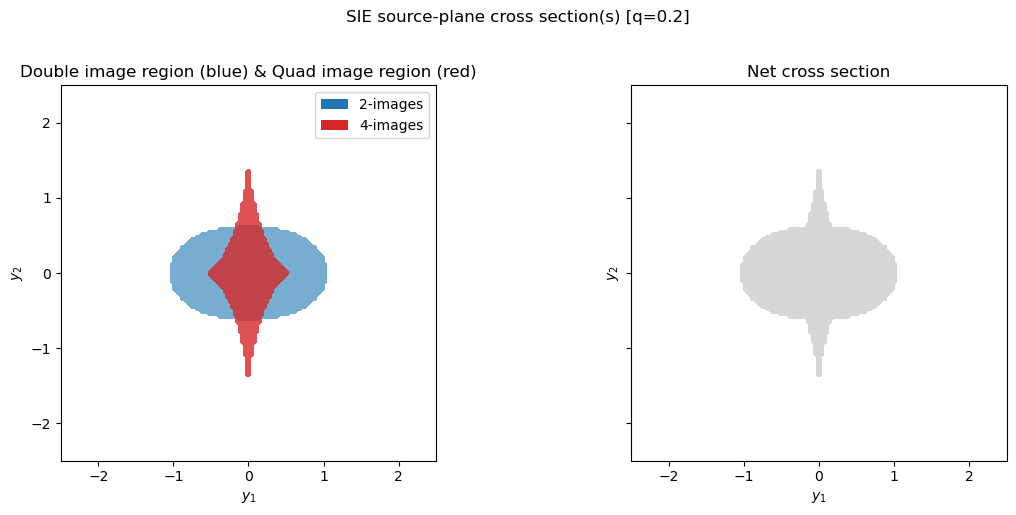

In [19]:
q = 0.2
sigma_2_sis, sigma_4_sis, sigma_net_sis, *_ = cross_sections_for_q(0.999, Ny=150)
s2, s4, sm, y1, y2, m2, m4, mnet = cross_sections_for_q(q, Ny=150)
sie2img = s2/sigma_net_sis
sie4img = s4/sigma_net_sis
sieNet = sm/sigma_net_sis
print("SIE 2-image cross-section (normalized to SIS): ", sie2img)
print("SIE 4-image cross-section (normalized to SIS): ", sie4img)
print("SIE total cross-section (normalized to SIS): ", sieNet)

# ==================================================
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# --------------------------------------------------------
# (A) 2-image (double) and 4-image (quad) regions together
# --------------------------------------------------------
axes[0].contourf(y1, y2, m2, levels=[0.5,1], colors=['tab:blue'], alpha=0.6)
axes[0].contourf(y1, y2, m4, levels=[0.5,1], colors=['tab:red'], alpha=0.8)

axes[0].set_title("Double image region (blue) & Quad image region (red)")
axes[0].set_xlabel(r"$y_1$")
axes[0].set_ylabel(r"$y_2$")
axes[0].set_aspect('equal', adjustable='box')

legend_elements = [
    Patch(facecolor='tab:blue', label='2-images'),
    Patch(facecolor='tab:red', label='4-images')
]
axes[0].legend(handles=legend_elements, loc='upper right')

# --------------------------------------------------
# (B) Net image region
# --------------------------------------------------
axes[1].contourf(y1, y2, mnet, levels=[0.5,1], colors=['lightgray'], alpha=0.9)
axes[1].set_title("Net cross section")
axes[1].set_xlabel(r"$y_1$")
axes[1].set_ylabel(r"$y_2$")
axes[1].set_aspect('equal', adjustable='box')

plt.suptitle(fr"SIE source-plane cross section(s) [q={q}]", y=1.02)
plt.tight_layout()
plt.show()


Velocity dispersion function
#### $ \phi(\sigma) \equiv \frac{dn}{d\sigma} = \phi_{*,0} \left(\frac{\sigma}{\sigma_{*,0}}\right)^\alpha exp\left[-\left( \frac{\sigma}{\sigma_{*,0}}\right)^\beta\right] \frac{\beta}{\Gamma(\alpha/\beta) \sigma} $

where $\phi_{*,0} = 8\times10^{-3}$ $h^3 Mpc^{-3}$, $\sigma_{*,0} = 161$ km $s^{-1}$, $\alpha = 2.32$, and $\beta = 2.67$ (Choi et al. + 2007)

and $\phi_{*,0} = 2.099 \times 10^{-2} (h/0.7)^3$ $Mpc^{-3}$, $\sigma_{*,0} = 113.78$ km $s^{-1}$, $\alpha = 0.94$, and $\beta = 1.85$ (Bernardi et al. + 2010)

A parametric redshift-dependent model of the VDF is given by,

$\phi_*(z) = \phi_{*,0} (1 + z)^{\nu_n} \text{ , } \sigma_*(z) = \sigma_{*,0} (1 + z)^{\nu_\nu}$

where $\nu_n = -1.18$, and $\nu_\nu = 0.18$

In [20]:
def dn_dsigma_bernardi2010(sigma, z_L, nu_n=-1.18, nu_nu=0.18, h=0.7):
    phi_star_0 = 2.099e-2 * (h/0.7)**3 * u.Mpc**-3 * (1 + z_L)**nu_n  # (h/0.7)^3 Mpc^-3
    sigma_star_0 = 113.78 * u.km / u.s * (1 + z_L)**nu_nu
    alpha = 0.94
    beta = 1.85
    coeff = beta / (math.gamma(alpha / beta) * sigma)
    exponent = - (sigma / sigma_star_0)**beta
    power_law = (sigma / sigma_star_0)**alpha
    return phi_star_0 * power_law * np.exp(exponent) * coeff

In [21]:
def d2tau_dzL_dsigma_z(sigma, z_L, z_s, lens_model='SIS'):
    dn_dsigma_bernardi_z = dn_dsigma_bernardi2010(sigma, z_L)
    theta_E = 4 * np.pi * (sigma / const.c)**2 * (cosmo.angular_diameter_distance_z1z2(z_L, z_s) / cosmo.angular_diameter_distance(z_s))
    
    D_ls = cosmo.angular_diameter_distance_z1z2(z_L, z_s)
    D_s  = cosmo.angular_diameter_distance(z_s)
    D_l  = cosmo.angular_diameter_distance(z_L)

    theta_E = (4 * np.pi * (sigma / const.c)**2 * (D_ls / D_s)).decompose()

    if lens_model == 'SIS':
        sigma_lens = (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_2img':
        sigma_lens = sie2img * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_4img':
        sigma_lens = sie4img * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_net':
        sigma_lens = sieNet * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    else:
        raise ValueError("Unsupported lens model")
    
    dl_dz = (const.c / cosmo.H(z_L)) * (1 + z_L)**2
    return dn_dsigma_bernardi_z * sigma_lens * dl_dz

def d2tau_dzL_dsigma_0(sigma, z_L, z_s, lens_model='SIS'):
    dn_dsigma_bernardi_0 = dn_dsigma_bernardi2010(sigma, 0)
    theta_E = 4 * np.pi * (sigma / const.c)**2 * (cosmo.angular_diameter_distance_z1z2(z_L, z_s) / cosmo.angular_diameter_distance(z_s))
    
    D_ls = cosmo.angular_diameter_distance_z1z2(z_L, z_s)
    D_s  = cosmo.angular_diameter_distance(z_s)
    D_l  = cosmo.angular_diameter_distance(z_L)

    theta_E = (4 * np.pi * (sigma / const.c)**2 * (D_ls / D_s)).decompose()

    if lens_model == 'SIS':
        sigma_lens = (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_2img':
        sigma_lens = sie2img * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_4img':
        sigma_lens = sie4img * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    elif lens_model == 'SIE_net':
        sigma_lens = sieNet * (np.pi * (D_l * theta_E)**2).to(u.Mpc**2)
    else:
        raise ValueError("Unsupported lens model")
    
    dl_dz = (const.c / cosmo.H(z_L)) * (1 + z_L)**2
    return dn_dsigma_bernardi_0 * sigma_lens * dl_dz

print(d2tau_dzL_dsigma_z(200*u.km/u.s, 0.5, 2.0, lens_model='SIS'))
print(d2tau_dzL_dsigma_z(200*u.km/u.s, 0.5, 2.0, lens_model='SIE_net'))
print(d2tau_dzL_dsigma_0(200*u.km/u.s, 0.5, 2.0, lens_model='SIS'))
print(d2tau_dzL_dsigma_0(200*u.km/u.s, 0.5, 2.0, lens_model='SIE_net'))


0.004594846845129651 m s / km2
0.0034247713967275363 m s / km2
0.005547814900328067 m s / km2
0.0041350666138353686 m s / km2


In [22]:
def integrand_logsigma_z(ln_sigma, z_L, z_s, lens_model):
    sigma = np.exp(ln_sigma) * u.km / u.s ## change of variable
    val = sigma * d2tau_dzL_dsigma_z(sigma=sigma, z_L=z_L, z_s=z_s, lens_model=lens_model)
    return val.to_value(u.dimensionless_unscaled) #dimensionless


def tau_z(z_s, lens_model='SIS', sigma_min=50*u.km/u.s, sigma_max=400*u.km/u.s, epsrel=1e-6, epsabs=1e-8):
    ln_sigma_min = np.log(sigma_min.to_value(u.km/u.s))
    ln_sigma_max = np.log(sigma_max.to_value(u.km/u.s))

    def inner_sigma(z_L):
        val, err = quad(integrand_logsigma_z, ln_sigma_min, ln_sigma_max, args=(z_L, z_s, lens_model), epsrel=epsrel, epsabs=epsabs)
        return val

    tau_val, err = quad(inner_sigma, 0.0, z_s, epsrel=epsrel, epsabs=epsabs)

    return tau_val


def integrand_logsigma_0(ln_sigma, z_L, z_s, lens_model):
    sigma = np.exp(ln_sigma) * u.km / u.s
    val = sigma * d2tau_dzL_dsigma_0(sigma=sigma, z_L=z_L, z_s=z_s, lens_model=lens_model)
    return val.to_value(u.dimensionless_unscaled) #dimensionless

def tau_0(z_s, lens_model='SIS', sigma_min=50*u.km/u.s, sigma_max=400*u.km/u.s, epsrel=1e-6, epsabs=1e-8):
    ln_sigma_min = np.log(sigma_min.to_value(u.km/u.s))
    ln_sigma_max = np.log(sigma_max.to_value(u.km/u.s))

    def inner_sigma(z_L):
        val, err = quad(integrand_logsigma_0, ln_sigma_min, ln_sigma_max, args=(z_L, z_s, lens_model), epsrel=epsrel, epsabs=epsabs)
        return val

    tau_val, err = quad(inner_sigma, 0.0, z_s, epsrel=epsrel, epsabs=epsabs)

    return tau_val



In [23]:
print("Redshift-dependent")
print(tau_z(2.0, lens_model='SIS'))
print(tau_z(2.0, lens_model='SIE_net'))
print(tau_z(2.0, lens_model='SIE_2img'))
print(tau_z(2.0, lens_model='SIE_4img'))
print("-----")
print("Redshift-independent")
print(tau_0(2.0, lens_model='SIS'))
print(tau_0(2.0, lens_model='SIE_net'))
print(tau_0(2.0, lens_model='SIE_2img'))
print(tau_0(2.0, lens_model='SIE_4img'))


Redshift-dependent
0.0007215909869929351
0.0005378382034668371
0.0004841576150210108
0.00023536873395477718
-----
Redshift-independent
0.0009268487104782921
0.0006908271504423321
0.0006218770317801415
0.00030231975105729703


In [24]:
from tqdm import tqdm

#z_s_grid = np.linspace(0.1, 3.0, 30)
z_s_grid = np.geomspace(1.e-2, 2.e1, 30)
tau_z_grid_SIS = np.array([tau_z(z_s, lens_model='SIS') for z_s in tqdm(z_s_grid)])
tau_z_grid_SIE_net = np.array([tau_z(z_s, lens_model='SIE_net') for z_s in tqdm(z_s_grid)])
tau_z_grid_SIE_2img = np.array([tau_z(z_s, lens_model='SIE_2img') for z_s in tqdm(z_s_grid)])
tau_z_grid_SIE_4img = np.array([tau_z(z_s, lens_model='SIE_4img') for z_s in tqdm(z_s_grid)])

tau_0_grid_SIS = np.array([tau_0(z_s, lens_model='SIS') for z_s in tqdm(z_s_grid)])
tau_0_grid_SIE_net = np.array([tau_0(z_s, lens_model='SIE_net') for z_s in tqdm(z_s_grid)])
tau_0_grid_SIE_2img = np.array([tau_0(z_s, lens_model='SIE_2img') for z_s in tqdm(z_s_grid)])
tau_0_grid_SIE_4img = np.array([tau_0(z_s, lens_model='SIE_4img') for z_s in tqdm(z_s_grid)])

100%|██████████| 30/30 [00:08<00:00,  3.43it/s]


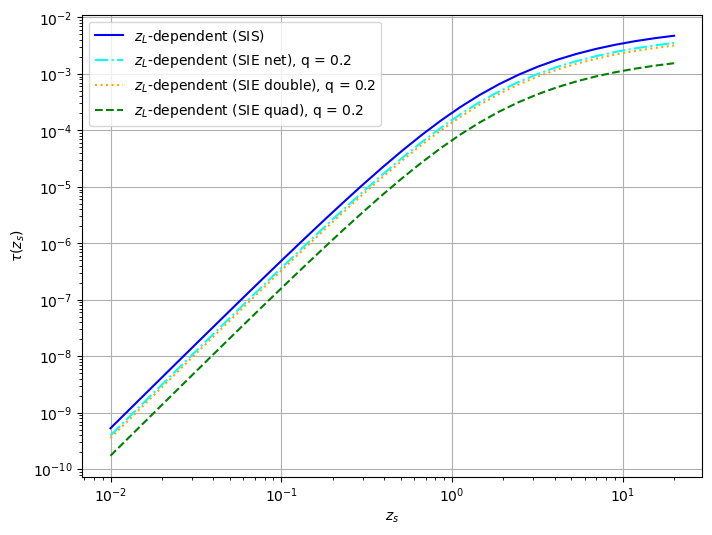

In [25]:
plt.figure(figsize=(8,6))
plt.plot(z_s_grid, tau_z_grid_SIS, label=r'$z_L$-dependent (SIS)', color='blue')
plt.plot(z_s_grid, tau_z_grid_SIE_net, label=rf'$z_L$-dependent (SIE net), q = {q}', linestyle='-.', color='cyan')
plt.plot(z_s_grid, tau_z_grid_SIE_2img, label=rf'$z_L$-dependent (SIE double), q = {q}', linestyle=':', color='orange')
plt.plot(z_s_grid, tau_z_grid_SIE_4img, label=rf'$z_L$-dependent (SIE quad), q = {q}', linestyle='--', color='green')
#plt.plot(z_s_grid, tau_0_grid_SIS, label=r'$z_L$-independent (SIS)', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_net, label=r'$z_L$-independent (SIE net)', linestyle='--', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_2img, label=r'$z_L$-independent (SIE double)', linestyle='-.', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_4img, label=r'$z_L$-independent (SIE quad)', linestyle=':', color='red')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau(z_s)$')
#plt.title('Strong Lensing Optical Depth as a Function of Source Redshift')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [30]:
tau_SIE_quad_test = tau_z_grid_SIE_4img[-1]
tau_SIS_test = tau_z_grid_SIS[-1]
fraction_test = tau_SIS_test/tau_SIE_quad_test
print(rf"tau_SIE: {tau_SIE_quad_test:.2e}")
print(rf"tau_SIS: {tau_SIS_test:.2e}")
print(rf"Fraction of SIS and SIE quad optical depth: {fraction_test:.2f}")

tau_SIE: 1.55e-03
tau_SIS: 4.75e-03
Fraction of SIS and SIE quad optical depth: 3.07


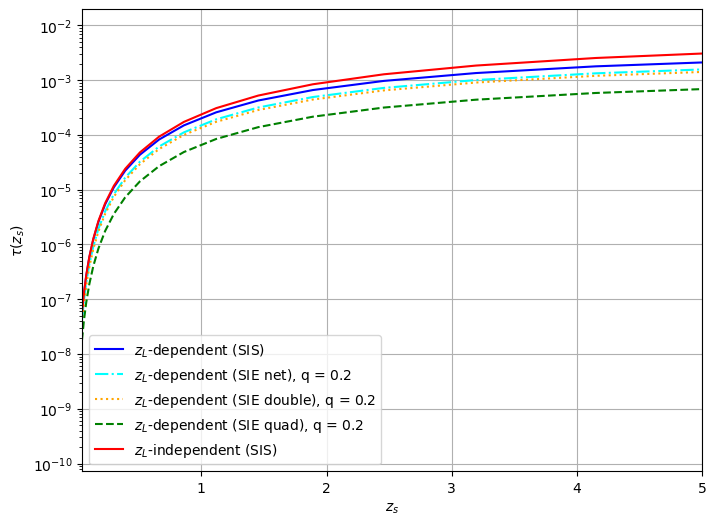

In [27]:
plt.figure(figsize=(8,6))
plt.plot(z_s_grid, tau_z_grid_SIS, label=r'$z_L$-dependent (SIS)', color='blue')
plt.plot(z_s_grid, tau_z_grid_SIE_net, label=rf'$z_L$-dependent (SIE net), q = {q}', linestyle='-.', color='cyan')
plt.plot(z_s_grid, tau_z_grid_SIE_2img, label=rf'$z_L$-dependent (SIE double), q = {q}', linestyle=':', color='orange')
plt.plot(z_s_grid, tau_z_grid_SIE_4img, label=rf'$z_L$-dependent (SIE quad), q = {q}', linestyle='--', color='green')
plt.plot(z_s_grid, tau_0_grid_SIS, label=r'$z_L$-independent (SIS)', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_net, label=r'$z_L$-independent (SIE net)', linestyle='--', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_2img, label=r'$z_L$-independent (SIE double)', linestyle='-.', color='red')
#plt.plot(z_s_grid, tau_0_grid_SIE_4img, label=r'$z_L$-independent (SIE quad)', linestyle=':', color='red')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau(z_s)$')
#plt.title('Strong Lensing Optical Depth as a Function of Source Redshift')
plt.xlim(0.05, 5)
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()